# <span style='color:green'>MUCH NEEDED LIBRARIES</span>

In [188]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

# <span style="color: green;">READING IN DATA</span>

In [10]:
# Reading in dataset
# Specify filenames of datasets
all_income = 'final_cleaned_dummy_data.csv'
low_income = 'lowIncomeFilteredData.csv'
response_var = 'BURDEN'

# Specify columns to keep
Predictors = ['ACPRIMARY_0', 'ACPRIMARY_1', 'ACPRIMARY_2', 'ACPRIMARY_3', 'ACPRIMARY_4', 'ACPRIMARY_5', 'ACPRIMARY_6', 'ACPRIMARY_7', 'BLD_1', 'BLD_2', 'BLD_3', 'BLD_4', 'BLD_5', 'BLD_6', 'BLD_7', 'BLD_8', 'BLD_9', 'COOKFUEL_0', 'COOKFUEL_1', 'COOKFUEL_2', 'COOKFUEL_3', 'COOKFUEL_4', 'DIVISION_1', 'DIVISION_2', 'DIVISION_3', 'DIVISION_4', 'DIVISION_5', 'DIVISION_6', 'DIVISION_7', 'DIVISION_8', 'DIVISION_9', 'HEATFUEL_0', 'HEATFUEL_1', 'HEATFUEL_2', 'HEATFUEL_3', 'HEATFUEL_4', 'HEATFUEL_5', 'HEATFUEL_6', 'HEATFUEL_7', 'HEATFUEL_8', 'HEATFUEL_9', 'HEATTYPE_0', 'HEATTYPE_1', 'HEATTYPE_2', 'HEATTYPE_3', 'HEATTYPE_4', 'HEATTYPE_5', 'HEATTYPE_6', 'HEATTYPE_7', 'HEATTYPE_8', 'HEATTYPE_9', 'HEATTYPE_10', 'HEATTYPE_11', 'HEATTYPE_12', 'HEATTYPE_13', 'HHRACE_1.0', 'HHRACE_2.0', 'HHRACE_3.0', 'HHRACE_4.0', 'HHRACE_5.0', 'HHRACE_6.0', 'HOTWATER_0', 'HOTWATER_1', 'HOTWATER_2', 'HOTWATER_3', 'HOTWATER_4', 'HOTWATER_5', 'HOTWATER_6', 'TENURE_0.0', 'TENURE_1.0', 'TENURE_2.0', 'FIREPLACE', 'NUMELDERS', 'NUMYNGKIDS', 'NUMOLDKIDS', 'URBAN', 'SOLAR', 'UNITSIZE', 'YRBUILT']

In [11]:
# Function to read files to dataframe
def read_to_df(filename, response, Keep_list):
    data = pd.read_csv(filename)
    y = data[response]
    
    # Dropping infinite and nan values of y and corresponding index of data
    j = 0
    for i in y:
        if i == float('inf'):
            y = y.drop([j])
            data = data.drop([j])
        elif np.isnan(i) == True:
            y = y.drop([j])
            data = data.drop([j])
        j += 1
    
    # Agnostic drop code (can drop any column as long as it contains specific word)
    for i in data:
        if i not in Keep_list:
            data = data.drop([i], axis=1)

    return y, data

In [107]:
# Creating the datasets (cleaned and filtered)

# All Income both (urban and rural)
y_all, all_income_df = read_to_df(all_income, response_var, Predictors)
                   
# Low Income both (urban and rural)
y_low, low_income_df = read_to_df(low_income, response_var, Predictors)

# <span style="color: red;">SIMPLE LINEAR REGRESSION</span>

In [60]:
# Creating model runs (6)

# Urban
def Urban_set(data, y):
    index = data.index
    j = 0
    for i in data['URBAN']:
        if i == 0:
            data = data.drop([index[j]])
            y = y.drop([index[j]])
        j += 1
    return data, y

# Rural
def Rural_set(data, y):
    index = data.index
    j = 0
    for i in data['URBAN']:
        if i == 1:
            data = data.drop([index[j]])
            y = y.drop([index[j]])
        j += 1
    return data, y

In [61]:
# All Urban
all_income_df_urban, y_all_urban = Urban_set(all_income_df, y_all)

# All Rural
all_income_df_rural, y_all_rural = Rural_set(all_income_df, y_all)

# Low Urban
low_income_df_urban, y_low_urban = Urban_set(low_income_df, y_low)

# Low Rural
low_income_df_rural, y_low_rural = Rural_set(low_income_df, y_low)

In [71]:
# Simple linear regression with best predictor
def SLR(data_train, data_val, y_train, y_val):
    
    # Find best predictor
    compare = 0
    for i in data_train.columns:
        
        data_basis_train = data_train[i]
        data_basis_train = np.array(data_basis_train).reshape(-1, 1)
        
        data_basis_val = data_val[i]
        data_basis_val = np.array(data_basis_val).reshape(-1, 1)
        
        regr = linear_model.LinearRegression().fit(data_basis_train, y_train)
        
        y_pred_val = regr.predict(data_basis_val)
        y_pred_train = regr.predict(data_basis_train)
        
        if r2_score(y_val, y_pred_val) > compare:
            y_pred_best_val = y_pred_val
            compare_val = r2_score(y_val, y_pred_val)
            predictor_best_val = i
            
        if r2_score(y_train, y_pred_train) > compare:
            y_pred_best_train = y_pred_train
            compare_train = r2_score(y_train, y_pred_train)
            predictor_best_train = i
    
    MSE_val = mse(y_val, y_pred_best_val)
    MSE_train = mse(y_train, y_pred_best_train)

    return y_pred_best_val, predictor_best_val, compare_val, MSE_val, y_pred_best_train, predictor_best_train, compare_train, MSE_train

# <span style="color: blue;">Unskewed response variable [USING]</span>

In [128]:
# Unskew parameter
percentile = 97.5
def response_unskew(data, y):
    p = np.percentile(y, percentile)
    index = y.index
    j = 0
    for i in y:
        if i > p:
            y = y.drop([index[j]])
            data = data.drop([index[j]])
        elif i <= 0:
            y = y.drop([index[j]])
            data = data.drop([index[j]])
        j += 1
    return data, y

# <span style="color: blue">Convert Categorical response [NOT USING]</span>

In [64]:
def continuous_to_categorical(y):
    p1 = np.percentile(y, 20)
    p2 = np.percentile(y, 40)
    p3 = np.percentile(y, 60)
    p4 = np.percentile(y, 80)
    p5 = np.percentile(y, 100)
    PL = [p1, p2, p3, p4, p5]
    a = 0
    for i in PL:
        for j in y:
            if i >= j:
                y[y.tolist().index(j)] = a
        a+= 1
    return y

# <span style="color: green;">Income to Energy Burden Plot</span>

In [129]:
# Pre-analysis datasets
y_all_dirty, all_income_df_dirty = read_to_df(all_income, response_var, Predictors+['HINCP'])
ADFD_unskew, YAD_unskew = response_unskew(all_income_df_dirty, y_all_dirty)

y_low_dirty, low_income_df_dirty = read_to_df(low_income, response_var, Predictors+['HINCP'])
LDFD_unskew, YLD_unskew = response_unskew(low_income_df_dirty, y_low_dirty)

In [159]:
# Percentile Lines
PL90, PL90L = [], []
PL50, PL50L = [], []
PL25, PL25L = [], []
for i in YAD_unskew:
    PL90.append(float(np.percentile(ADFD_unskew['HINCP'],90)))
    PL50.append(float(np.percentile(ADFD_unskew['HINCP'],50)))
    PL25.append(float(np.percentile(ADFD_unskew['HINCP'],25)))
for i in YLD_unskew:
    PL90L.append(float(np.percentile(LDFD_unskew['HINCP'],90)))
    PL50L.append(float(np.percentile(LDFD_unskew['HINCP'],50)))
    PL25L.append(float(np.percentile(LDFD_unskew['HINCP'],25)))

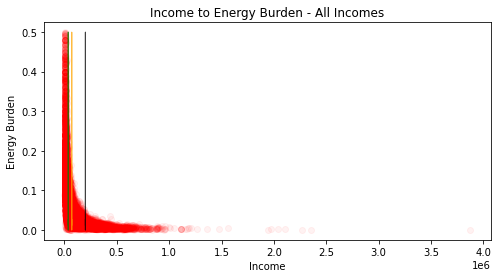

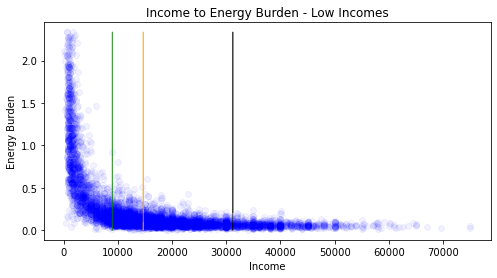

In [170]:
# Plotting
# Size All
A = plt.figure()
A.set_figwidth(8)
A.set_figheight(4)

# All Income
plt.scatter(ADFD_unskew['HINCP'], YAD_unskew, color='red', alpha=0.05)
plt.plot(PL90, YAD_unskew, linewidth=1, color='black', alpha=0.75)
plt.plot(PL50, YAD_unskew, linewidth=1, color='orange', alpha=0.75)
plt.plot(PL25, YAD_unskew, linewidth=1, color='green', alpha=0.75)
plt.title('Income to Energy Burden - All Incomes')
plt.xlabel('Income')
plt.ylabel('Energy Burden')
plt.show()

# Size Low
L = plt.figure()
L.set_figwidth(8)
L.set_figheight(4)

# Low Income
plt.scatter(LDFD_unskew['HINCP'], YLD_unskew, color='blue', alpha=0.05)
plt.plot(PL90L, YLD_unskew, linewidth=1, color='black', alpha=0.75)
plt.plot(PL50L, YLD_unskew, linewidth=1, color='orange', alpha=0.75)
plt.plot(PL25L, YLD_unskew, linewidth=1, color='green', alpha=0.75)
plt.title('Income to Energy Burden - Low Incomes')
plt.xlabel('Income')
plt.ylabel('Energy Burden')
plt.show()

# <span style="color: blue;">Train-Test Split</span>

The idea is to perform tt_split over each set of model data THEN carry the following test and validation sets through the predictor filtering processes (SLR best predictor, Lasso):
- SLR: Find predictor with lowest RSS and model with that
   - Using each model run (set of predictors), compare validation MSE and R2  with validation score and test MSE of RF
- MLR: Regular MLR
    - Using each model run (set of predictors), compare validation MSE and R2  with validation score and test MSE of RF
- Lasso
    - Using each model run (set of predictors), compare validation MSE and R2  with validation score and test MSE of RF

In [184]:
# Unskew data
# Convention: all_income_df (ADF), low_income_df (LDF), y_all (YA), y_low (YL)
# Convention: Urban (U), Rural (R)

# Both
ADF, YA = response_unskew(all_income_df, y_all)
LDF, YL = response_unskew(low_income_df, y_low)

# Rural
ADF_R, YA_R = response_unskew(all_income_df_rural, y_all_rural)
LDF_R, YL_R = response_unskew(low_income_df_rural, y_low_rural)

# Urban
ADF_U, YA_U = response_unskew(all_income_df_urban, y_all_urban)
LDF_U, YL_U = response_unskew(low_income_df_urban, y_low_urban)

In [69]:
def tt_split(data, response, split, random):
    X_train, X_val, y_train, y_val = train_test_split(data, response, test_size = split, random_state = random)
    return X_train, X_val, y_train, y_val

In [70]:
# Both
ADF_train, ADF_val, YA_train, YA_val = tt_split(ADF, YA, 0.2, 0)
LDF_train, LDF_val, YL_train, YL_val = tt_split(LDF, YL, 0.2, 0)

# Urban
ADF_train_U, ADF_val_U, YA_train_U, YA_val_U = tt_split(ADF_U, YA_U, 0.2, 0)
LDF_train_U, LDF_val_U, YL_train_U, YL_val_U = tt_split(LDF_U, YL_U, 0.2, 0)

# Rural
ADF_train_R, ADF_val_R, YA_train_R, YA_val_R = tt_split(ADF_R, YA_R, 0.2, 0)
LDF_train_R, LDF_val_R, YL_train_R, YL_val_R = tt_split(LDF_R, YL_R, 0.2, 0)

In [73]:
# SLR (8 Outputs)
# SLR(data_train, data_val, y_train, y_val)
# y_pred_best_val, predictor_best_val, compare_val, MSE_val, 
# y_pred_best_train, predictor_best_train, compare_train, MSE_train
# Convention: YPBV, PBV, CV, MSEV, YPBT, PBT, CT, MSET

# Both
YPBV_ADF, PBV_ADF, CV_ADF, MSEV_ADF, YPBT_ADF, PBT_ADF, CT_ADF, MSET_ADF = SLR(ADF_train, ADF_val, YA_train, YA_val)

YPBV_LDF, PBV_LDF, CV_LDF, MSEV_LDF, YPBT_LDF, PBT_LDF, CT_LDF, MSET_LDF = SLR(LDF_train, LDF_val, YL_train, YL_val)

# Urban
YPBV_ADF_U, PBV_ADF_U, CV_ADF_U, MSEV_ADF_U, YPBT_ADF_U, PBT_ADF_U, CT_ADF_U, MSET_ADF_U = SLR(ADF_train_U, ADF_val_U, YA_train_U, YA_val_U)

YPBV_LDF_U, PBV_LDF_U, CV_LDF_U, MSEV_LDF_U, YPBT_LDF_U, PBT_LDF_U, CT_LDF_U, MSET_LDF_U = SLR(LDF_train_U, LDF_val_U, YL_train_U, YL_val_U)

# Rural
YPBV_ADF_R, PBV_ADF_R, CV_ADF_R, MSEV_ADF_R, YPBT_ADF_R, PBT_ADF_R, CT_ADF_R, MSET_ADF_R = SLR(ADF_train_R, ADF_val_R, YA_train_R, YA_val_R)

YPBV_LDF_R, PBV_LDF_R, CV_LDF_R, MSEV_LDF_R, YPBT_LDF_R, PBT_LDF_R, CT_LDF_R, MSET_LDF_R = SLR(LDF_train_R, LDF_val_R, YL_train_R, YL_val_R)


In [83]:
def Plotter(data, pred, y, y_pred, title_):
    plt.scatter(data[pred], y, color='black', alpha = 0.25)
    plt.plot(data[pred], y_pred, color='green', linewidth=1)
    plt.title(title_)
    plt.xlabel(pred)
    plt.ylabel('Energy Burden')
    plt.show()
    return

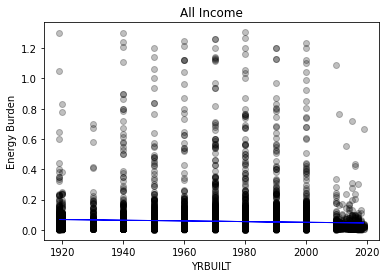

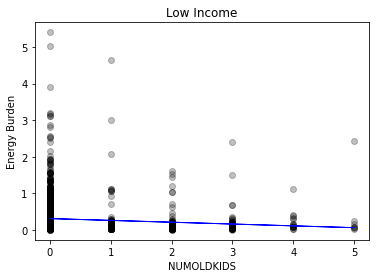

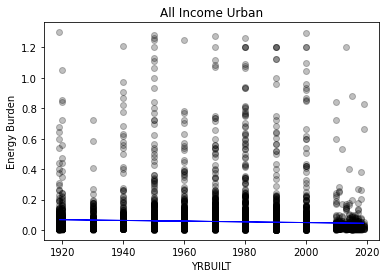

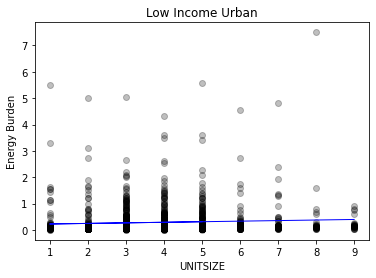

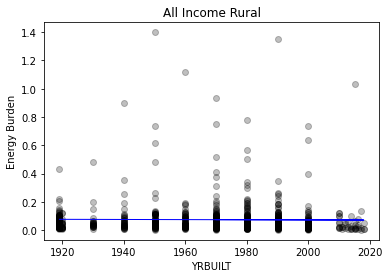

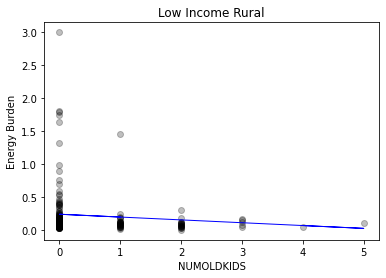

In [84]:
# Plot All Income
Plotter(ADF_val, PBV_ADF, YA_val, YPBV_ADF, 'All Income')

# Plot Low Income
Plotter(LDF_val, PBV_LDF, YL_val, YPBV_LDF, 'Low Income')

# Plot All Income Urban
Plotter(ADF_val_U, PBV_ADF_U, YA_val_U, YPBV_ADF_U, 'All Income Urban')

# Plot Low Income Urban
Plotter(LDF_val_U, PBV_LDF_U, YL_val_U, YPBV_LDF_U, 'Low Income Urban')

# Plot All Income Rural
Plotter(ADF_val_R, PBV_ADF_R, YA_val_R, YPBV_ADF_R, 'All Income Rural')

# Plot Low Income Rural
Plotter(LDF_val_R, PBV_LDF_R, YL_val_R, YPBV_LDF_R, 'Low Income Rural')

In [96]:
# Best R2 and MSE (validation set)

# All Income
print('Best R2 of SLR on all income: ', CV_ADF)
print('Validation MSE on all income: ', MSEV_ADF)
print('\n')
# Low Income
print('Best R2 of SLR on low income: ', CV_LDF)
print('Validation MSE on low income: ', MSEV_LDF)
print('\n')
# All Income Urban
print('Best R2 of SLR on all income Urban: ', CV_ADF_U)
print('Validation MSE on all income Urban: ', MSEV_ADF_U)
print('\n')
# Low Income Urban
print('Best R2 of SLR on low income Urban: ', CV_LDF_U)
print('Validation MSE on low income Urban: ', MSEV_LDF_U)
print('\n')
# All Income Rural
print('Best R2 of SLR on all income Rural: ', CV_ADF_R)
print('Validation MSE on all income Rural: ', MSEV_ADF_R)
print('\n')
# Low Income Rural
print('Best R2 of SLR on low income Rural: ', CV_LDF_R)
print('Validation MSE on low income Rural: ', MSEV_LDF_R)

Best R2 of SLR on all income:  0.0016671646909990345
Validation MSE on all income:  0.014079432343037325


Best R2 of SLR on low income:  0.0018131130513611149
Validation MSE on low income:  0.20501533952321907


Best R2 of SLR on all income Urban:  0.0019485334019277989
Validation MSE on all income Urban:  0.014112390313039389


Best R2 of SLR on low income Urban:  0.000118339432038983
Validation MSE on low income Urban:  0.3342350305404434


Best R2 of SLR on all income Rural:  2.909469703271661e-06
Validation MSE on all income Rural:  0.016226818388420227


Best R2 of SLR on low income Rural:  0.010803819310114426
Validation MSE on low income Rural:  0.11715325273139103


# <span style="color: red;">MULTIPLE LINEAR REGRESSION</span>

# <span style='color:blue'>Intercept Assigner</span>

In [97]:
def intercepter(data):
    data = data.assign(Intercept=1)
    return data

In [98]:
# Intercept
# All Income
ADF_trainI = intercepter(ADF_train)
ADF_valI = intercepter(ADF_val)

# Low Income
LDF_trainI = intercepter(LDF_train)
LDF_valI = intercepter(LDF_val)

# All Income Urban
ADF_trainI_U = intercepter(ADF_train_U)
ADF_valI_U = intercepter(ADF_val_U)

# Low Income Urban
LDF_trainI_U = intercepter(LDF_train_U)
LDF_valI_U = intercepter(LDF_val_U)

# All Income Rural
ADF_trainI_R = intercepter(ADF_train_R)
ADF_valI_R = intercepter(ADF_val_R)

# Low Income Rural
LDF_trainI_R = intercepter(LDF_train_R)
LDF_valI_R = intercepter(LDF_val_R)

In [99]:
def MLR(data_train, data_val, y_train, y_val):
    # Creating the model
    sm_model = sm.OLS(y_train, data_train)

    # Multiple Linear Regression
    results = sm_model.fit()
    y_pred_val = results.predict(data_val)
    y_pred_train = results.predict(data_train)

    # Summary
    data_summary = results.summary()
    MSE_val = rmse(y_val, y_pred_val)
    MSE_train = rmse(y_train, y_pred_train)
    
    return data_summary, MSE_val, MSE_train

In [100]:
# 6 Model run MLR (3 outputs)
# All Income
ADF_data_summary, ADF_MSE_val, ADF_MSE_train = MLR(ADF_trainI, ADF_valI, YA_train, YA_val)
# Low Income
LDF_data_summary, LDF_MSE_val, LDF_MSE_train = MLR(LDF_trainI, LDF_valI, YL_train, YL_val)
# All Income Urban
ADF_data_summary_U, ADF_MSE_val_U, ADF_MSE_train_U = MLR(ADF_trainI_U, ADF_valI_U, YA_train_U, YA_val_U)
# Low Income Urban
LDF_data_summary_U, LDF_MSE_val_U, LDF_MSE_train_U = MLR(LDF_trainI_U, LDF_valI_U, YL_train_U, YL_val_U)
# All Income Rural
ADF_data_summary_R, ADF_MSE_val_R, ADF_MSE_train_R = MLR(ADF_trainI_R, ADF_valI_R, YA_train_R, YA_val_R)
# Low Income Rural
LDF_data_summary_R, LDF_MSE_val_R, LDF_MSE_train_R = MLR(LDF_trainI_R, LDF_valI_R, YL_train_R, YL_val_R)

In [101]:
# All Income
display(ADF_data_summary)
print('ADF MSE val: ', ADF_MSE_val)
print('ADF MSE train: ', ADF_MSE_train)
# Low Income
display(LDF_data_summary)
print('ADF MSE val: ', LDF_MSE_val)
print('ADF MSE train: ', LDF_MSE_train)
# All Income Urban
display(ADF_data_summary_U)
print('ADF MSE val: ', ADF_MSE_val_U)
print('ADF MSE train: ', ADF_MSE_train_U)
# Low Income Urban
display(LDF_data_summary_U)
print('ADF MSE val: ', LDF_MSE_val_U)
print('ADF MSE train: ', LDF_MSE_train_U)
# All Income Rural
display(ADF_data_summary_R)
print('ADF MSE val: ', ADF_MSE_val_R)
print('ADF MSE train: ', ADF_MSE_train_R)
# Low Income Rural
display(LDF_data_summary_R)
print('ADF MSE val: ', LDF_MSE_val_R)
print('ADF MSE train: ', LDF_MSE_train_R)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BURDEN   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     27.38
Date:                Sat, 11 Dec 2021   Prob (F-statistic):               0.00
Time:                        16:21:24   Log-Likelihood:                 28011.
No. Observations:               34926   AIC:                        -5.588e+04
Df Residuals:                   34856   BIC:                        -5.529e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ACPRIMARY_0     0.0163      0.004      4.318      0.000       0.009       0.024
ACPRIMARY_1     0.0197      0.004      5.271      0.000       0.012       0.027
ACPRIMARY_2     0.0239      0.005      4.612      0.000       0.014       0.034
ACPRIMARY_3     0.0128      0.012      1.047      0.295      -0.011       0.037
ACPRIMARY_4     0.0241      0.004      6.108      0.000       0.016       0.032
ACPRIMARY_5     0.0188      0.004      4.628      0.000       0.011       0.027
ACPRIMARY_6     0.0132      0.005      2.896      0.004       0.004       0.022
ACPRIMARY_7     0.0158      0.005      2.881      0.004       0.005       0.027
BLD_1           0.0367      0.004      9.485      0.000       0.029       0.044
BLD_2           0.0162      0.003      6.023      0.000       0.011       0.021
BLD_3           0.0146      0.003      4.305      0.000       0.008       0.021
BLD_4           0.0184      0.004      4.525      0.000       0.010       0.026
BLD_5           0.0166      0.004      4.451      0.000       0.009       0.024
BLD_6           0.0176      0.004      4.854      0.000       0.011       0.025
BLD_7           0.0084      0.004      2.252      0.024       0.001       0.016
BLD_8           0.0045      0.004      1.130      0.258      -0.003       0.012
BLD_9           0.0114      0.004      2.919      0.004       0.004       0.019
COOKFUEL_0      0.0268      0.015      1.826      0.068      -0.002       0.056
COOKFUEL_1      0.0270      0.008      3.455      0.001       0.012       0.042
COOKFUEL_2      0.0305      0.008      3.894      0.000       0.015       0.046
COOKFUEL_3      0.0299      0.008      3.581      0.000       0.014       0.046
COOKFUEL_4      0.0304      0.025      1.195      0.232      -0.019       0.080
DIVISION_1      0.0210      0.004      5.558      0.000       0.014       0.028
DIVISION_2      0.0196      0.003      6.183      0.000       0.013       0.026
DIVISION_3      0.0158      0.003      5.526      0.000       0.010       0.021
DIVISION_4      0.0052      0.004      1.436      0.151      -0.002       0.012
DIVISION_5      0.0143      0.003      4.890      0.000       0.009       0.020
DIVISION_6      0.0251      0.004      6.713      0.000       0.018       0.032
DIVISION_7      0.0209      0.003      6.595      0.000       0.015       0.027
DIVISION_8      0.0194      0.003      5.683      0.000       0.013       0.026
DIVISION_9      0.0032      0.003      1.078      0.281      -0.003       0.009
HEATFUEL_0      0.0121      0.006      2.058      0.040       0.001       0.024
HEATFUEL_1      0.0125      0.006      2.101      0.036       0.001       0.024
HEATFUEL_2      0.0076      0.006      1.284      0.199      -0.004       0.019
HEATFUEL_3      0.0330      0.007      4.853      0.000       0.020       0.046
HEATFUEL_4      0.0161      0.007      2.32

ADF MSE val:  0.11644980918424404
ADF MSE train:  0.10850765709226587


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BURDEN   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     11.23
Date:                Sat, 11 Dec 2021   Prob (F-statistic):           6.59e-16
Time:                        16:21:24   Log-Likelihood:                -5357.9
No. Observations:                6382   AIC:                         1.073e+04
Df Residuals:                    6373   BIC:                         1.079e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FIREPLACE      0.0095      0.019      0.509      0.611      -0.027       0.046
NUMELDERS      0.0289      0.011      2.525      0.012       0.006       0.051
NUMYNGKIDS    -0.0280      0.014     -2.033      0.042      -0.055      -0.001
NUMOLDKIDS    -0.0430      0.008     -5.507      0.000      -0.058      -0.028
URBAN          0.0511      0.021      2.442      0.015       0.010       0.092
SOLAR         -0.0603      0.051     -1.186      0.236      -0.160       0.039
UNITSIZE       0.0171      0.005      3.655      0.000       0.008       0.026
YRBUILT       -0.0003      0.000     -1.171      0.242      -0.001       0.000
Intercept      0.8437      0.560      1.505      0.132      -0.255       1.942
==============================================================================
Omnibus:                     6380.439   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           316097.347
Skew:                           5.004   Prob(JB):                         0.00
Kurtosis:                      35.993   Cond. No.                     1.57e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

ADF MSE val:  0.45226366203359997
ADF MSE train:  0.5602317554234929


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BURDEN   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     24.47
Date:                Sat, 11 Dec 2021   Prob (F-statistic):          3.66e-294
Time:                        16:21:24   Log-Likelihood:                 25475.
No. Observations:               31745   AIC:                        -5.081e+04
Df Residuals:                   31676   BIC:                        -5.024e+04
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ACPRIMARY_0     0.0088      0.004      2.462      0.014       0.002       0.016
ACPRIMARY_1     0.0133      0.003      3.852      0.000       0.007       0.020
ACPRIMARY_2     0.0187      0.005      3.709      0.000       0.009       0.029
ACPRIMARY_3     0.0236      0.015      1.584      0.113      -0.006       0.053
ACPRIMARY_4     0.0160      0.004      4.196      0.000       0.009       0.024
ACPRIMARY_5     0.0106      0.004      2.664      0.008       0.003       0.018
ACPRIMARY_6     0.0004      0.005      0.092      0.927      -0.009       0.009
ACPRIMARY_7     0.0110      0.006      1.995      0.046       0.000       0.022
BLD_1           0.0331      0.004      8.775      0.000       0.026       0.041
BLD_2           0.0115      0.002      5.122      0.000       0.007       0.016
BLD_3           0.0091      0.003      3.047      0.002       0.003       0.015
BLD_4           0.0140      0.004      3.580      0.000       0.006       0.022
BLD_5           0.0140      0.003      4.119      0.000       0.007       0.021
BLD_6           0.0116      0.003      3.528      0.000       0.005       0.018
BLD_7           0.0081      0.003      2.367      0.018       0.001       0.015
BLD_8          -0.0018      0.004     -0.478      0.633      -0.009       0.005
BLD_9           0.0027      0.004      0.781      0.435      -0.004       0.010
COOKFUEL_0      0.0219      0.014      1.515      0.130      -0.006       0.050
COOKFUEL_1      0.0191      0.008      2.431      0.015       0.004       0.034
COOKFUEL_2      0.0226      0.008      2.864      0.004       0.007       0.038
COOKFUEL_3      0.0249      0.009      2.907      0.004       0.008       0.042
COOKFUEL_4      0.0141      0.027      0.512      0.609      -0.040       0.068
DIVISION_1      0.0150      0.004      4.258      0.000       0.008       0.022
DIVISION_2      0.0154      0.003      5.541      0.000       0.010       0.021
DIVISION_3      0.0112      0.002      4.556      0.000       0.006       0.016
DIVISION_4     -0.0021      0.004     -0.572      0.567      -0.009       0.005
DIVISION_5      0.0100      0.002      4.101      0.000       0.005       0.015
DIVISION_6      0.0212      0.004      5.788      0.000       0.014       0.028
DIVISION_7      0.0154      0.003      5.688      0.000       0.010       0.021
DIVISION_8      0.0154      0.003      5.107      0.000       0.009       0.021
DIVISION_9      0.0011      0.002      0.431      0.667      -0.004       0.006
HEATFUEL_0      0.0043      0.007      0.627      0.531      -0.009       0.018
HEATFUEL_1      0.0093      0.007      1.254      0.210      -0.005       0.024
HEATFUEL_2      0.0039      0.007      0.532      0.595      -0.011       0.018
HEATFUEL_3      0.0233      0.009      2.685      0.007       0.006       0.040
HEATFUEL_4      0.0133      0.008      1.58

ADF MSE val:  0.11651738786802483
ADF MSE train:  0.10845263517879565


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BURDEN   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     13.42
Date:                Sat, 11 Dec 2021   Prob (F-statistic):           2.68e-17
Time:                        16:21:24   Log-Likelihood:                -4887.8
No. Observations:                5548   AIC:                             9792.
Df Residuals:                    5540   BIC:                             9845.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FIREPLACE      0.0460      0.021      2.239      0.025       0.006       0.086
NUMELDERS      0.0144      0.013      1.121      0.262      -0.011       0.040
NUMYNGKIDS    -0.0371      0.015     -2.481      0.013      -0.067      -0.008
NUMOLDKIDS    -0.0452      0.009     -5.282      0.000      -0.062      -0.028
URBAN          1.1568      0.315      3.668      0.000       0.539       1.775
SOLAR         -0.0593      0.055     -1.086      0.278      -0.166       0.048
UNITSIZE       0.0214      0.005      4.139      0.000       0.011       0.032
YRBUILT       -0.0011      0.000     -3.308      0.001      -0.002      -0.000
Intercept      1.1568      0.315      3.668      0.000       0.539       1.775
==============================================================================
Omnibus:                     5891.005   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           399690.248
Skew:                           5.394   Prob(JB):                         0.00
Kurtosis:                      43.158   Cond. No.                     2.51e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.41e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

ADF MSE val:  0.5755938403789691
ADF MSE train:  0.5839572391052008


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BURDEN   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     3.490
Date:                Sat, 11 Dec 2021   Prob (F-statistic):           2.17e-19
Time:                        16:21:24   Log-Likelihood:                 2528.9
No. Observations:                3182   AIC:                            -4922.
Df Residuals:                    3114   BIC:                            -4509.
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ACPRIMARY_0     0.0171      0.011      1.509      0.132      -0.005       0.039
ACPRIMARY_1     0.0126      0.011      1.140      0.254      -0.009       0.034
ACPRIMARY_2     0.0704      0.022      3.245      0.001       0.028       0.113
ACPRIMARY_3    -0.0091      0.027     -0.337      0.736      -0.062       0.044
ACPRIMARY_4     0.0144      0.011      1.296      0.195      -0.007       0.036
ACPRIMARY_5     0.0048      0.011      0.424      0.671      -0.018       0.027
ACPRIMARY_6     0.0105      0.013      0.787      0.431      -0.016       0.037
ACPRIMARY_7    -0.0132      0.016     -0.810      0.418      -0.045       0.019
BLD_1           0.0180      0.011      1.568      0.117      -0.005       0.040
BLD_2          -0.0002      0.010     -0.024      0.981      -0.019       0.019
BLD_3          -0.0154      0.017     -0.929      0.353      -0.048       0.017
BLD_4           0.0125      0.014      0.905      0.366      -0.015       0.040
BLD_5        -7.68e-05      0.015     -0.005      0.996      -0.030       0.029
BLD_6          -0.0131      0.015     -0.886      0.376      -0.042       0.016
BLD_7           0.0198      0.017      1.140      0.254      -0.014       0.054
BLD_8           0.0778      0.020      3.799      0.000       0.038       0.118
BLD_9           0.0083      0.026      0.313      0.754      -0.044       0.060
COOKFUEL_0     -0.0301      0.050     -0.608      0.543      -0.127       0.067
COOKFUEL_1      0.0265      0.020      1.330      0.184      -0.013       0.065
COOKFUEL_2      0.0291      0.020      1.425      0.154      -0.011       0.069
COOKFUEL_3      0.0428      0.021      2.084      0.037       0.003       0.083
COOKFUEL_4      0.0394      0.046      0.854      0.393      -0.051       0.130
DIVISION_1      0.0034      0.013      0.263      0.793      -0.022       0.029
DIVISION_2      0.0272      0.011      2.428      0.015       0.005       0.049
DIVISION_3      0.0135      0.009      1.549      0.121      -0.004       0.031
DIVISION_4      0.0030      0.009      0.334      0.739      -0.014       0.020
DIVISION_5      0.0069      0.009      0.734      0.463      -0.012       0.025
DIVISION_6      0.0302      0.010      3.019      0.003       0.011       0.050
DIVISION_7      0.0237      0.010      2.360      0.018       0.004       0.043
DIVISION_8      0.0008      0.011      0.066      0.947      -0.022       0.023
DIVISION_9     -0.0010      0.012     -0.081      0.935      -0.024       0.023
HEATFUEL_0      0.0126      0.013      0.937      0.349      -0.014       0.039
HEATFUEL_1     -0.0013      0.012     -0.108      0.914      -0.024       0.022
HEATFUEL_2      0.0012      0.012      0.099      0.921      -0.022       0.024
HEATFUEL_3      0.0259      0.012      2.153      0.031       0.002       0.049
HEATFUEL_4      0.0285      0.014      2.01

ADF MSE val:  0.12727363602610398
ADF MSE train:  0.10929784637704039


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BURDEN   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.054
Date:                Sat, 11 Dec 2021   Prob (F-statistic):             0.0462
Time:                        16:21:24   Log-Likelihood:                -396.63
No. Observations:                 834   AIC:                             809.3
Df Residuals:                     826   BIC:                             847.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FIREPLACE     -0.0379      0.041     -0.914      0.361      -0.119       0.043
NUMELDERS      0.0171      0.022      0.777      0.438      -0.026       0.060
NUMYNGKIDS    -0.0011      0.025     -0.045      0.964      -0.050       0.048
NUMOLDKIDS    -0.0386      0.017     -2.338      0.020      -0.071      -0.006
URBAN      -1.016e-14   5.48e-15     -1.853      0.064   -2.09e-14    6.03e-16
SOLAR         -0.1264      0.125     -1.011      0.312      -0.372       0.119
UNITSIZE       0.0016      0.009      0.173      0.862      -0.016       0.019
YRBUILT        0.0011      0.001      2.088      0.037    6.73e-05       0.002
Intercept     -1.9748      1.062     -1.859      0.063      -4.059       0.110
==============================================================================
Omnibus:                      780.638   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21804.511
Skew:                           4.403   Prob(JB):                         0.00
Kurtosis:                      26.451   Cond. No.                     5.60e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.03e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

ADF MSE val:  0.3416539229467154
ADF MSE train:  0.38931743885468645


# <span style="color: blue;">Multicollinearity VIF Test [NOT USING]</span>

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# For each predictive variable, calculate VIF and save in a dataframe called "VIF"
def VIF(data):
    VIF = pd.DataFrame()
    VIF['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    VIF['Predictive Variable'] = data.columns
    VIF = VIF[VIF['Predictive Variable'] != 'Intercept']
    return VIF

# <span style="color: blue;">Re-test MLR with dropped Collinear Predictors [NOT USING]</span>

In [ ]:
def collinear_drop(VIF, data):
    j = 0
    for i in VIF['VIF']:
        if i >= 10:
            data = data.drop([VIF['Predictive Variable'][j]], axis=1)
        j += 1
    return data

# <span style="color: red;">LASSO</span>

# <span style="color: blue;">Scaling Data</span>

In [181]:
def Scaler(data):
    scaler = StandardScaler()
    scaler.fit(data)
    Scale_Feature_data = scaler.transform(data)
    return Scale_Feature_data

In [185]:
# Convention: Scaler (S), Train (T), Validation (V)
# X_train, X_val, y_train, y_val
# Feature standardization and split

# All Income
ADF_S = Scaler(ADF)
ADF_S_T, ADF_S_V, YA_S_T, YA_S_V = tt_split(ADF_S, YA, 0.2, 0)

# Low Income
LDF_S = Scaler(LDF)
LDF_S_T, LDF_S_V, YL_S_T, YL_S_V = tt_split(LDF_S, YL, 0.2, 0)

# All Income Urban
ADF_S_U = Scaler(ADF_U)
ADF_S_T_U, ADF_S_V_U, YA_S_T_U, YA_S_V_U = tt_split(ADF_S_U, YA_U, 0.2, 0)

# Low Income Urban
LDF_S_U = Scaler(LDF_U)
LDF_S_T_U, LDF_S_V_U, YL_S_T_U, YL_S_V_U = tt_split(LDF_S_U, YL_U, 0.2, 0)

# All Income Rural
ADF_S_R = Scaler(ADF_R)
ADF_S_T_R, ADF_S_V_R, YA_S_T_R, YA_S_V_R = tt_split(ADF_S_R, YA_R, 0.2, 0)

# Low Income Rural
LDF_S_R = Scaler(LDF_R)
LDF_S_T_R, LDF_S_V_R, YL_S_T_R, YL_S_V_R = tt_split(LDF_S_R, YL_R, 0.2, 0)

# <span style="color: blue;">Alpha from Cross Validation</span>

In [186]:
def AlphaCV(data_train, y_train):
    Lasso_scale = LassoCV(alphas=np.linspace(0.0001,5000,1000)).fit(data_train, y_train)
    Lasso_scale_alpha = Lasso_scale.score(data_train, y_train)
    return Lasso_scale_alpha

In [189]:
# Convention: Alpha (a)

# All Income
a_ADF = AlphaCV(ADF_S_T, YA_S_T)

# Low Income
a_LDF = AlphaCV(LDF_S_T, YL_S_T)

# All Income Urban
a_ADF_U = AlphaCV(ADF_S_T_U, YA_S_T_U)

# Low Income Urban
a_LDF_U = AlphaCV(LDF_S_T_U, YL_S_T_U)

# All Income Rural
a_ADF_R = AlphaCV(ADF_S_T_R, YA_S_T_R)

# Low Income Rural
a_LDF_R = AlphaCV(LDF_S_T_R, YL_S_T_R)

# <span style="color: blue;">Fitting Lasso Optimal Alpha</span>

In [190]:
def OptimalLasso(a, data_train, y_train, data_val, y_val):
    Lasso_optimal = Lasso(alpha = a)
    Lasso_optimal.fit(data_train, y_train)
    Lasso_optimal_mse = mse(y_val, Lasso_optimal.predict(data_val))
    return Lasso_optimal, Lasso_optimal_mse

In [192]:
# Convention: Lasso (l), optimal (o)

# All Income
lo_ADF, lo_ADF_MSE = OptimalLasso(a_ADF, ADF_S_T, YA_S_T, ADF_S_V, YA_S_V)
# Low Income
lo_LDF, lo_LDF_MSE = OptimalLasso(a_LDF, LDF_S_T, YL_S_T, LDF_S_V, YL_S_V)
# All Income Urban
lo_ADF_U, lo_ADF_MSE_U = OptimalLasso(a_ADF_U, ADF_S_T_U, YA_S_T_U, ADF_S_V_U, YA_S_V_U)
# Low Income Urban
lo_LDF_U, lo_LDF_MSE_U = OptimalLasso(a_LDF_U, LDF_S_T_U, YL_S_T_U, LDF_S_V_U, YL_S_V_U)
# All Income Rural
lo_ADF_R, lo_ADF_MSE_R = OptimalLasso(a_ADF_R, ADF_S_T_R, YA_S_T_R, ADF_S_V_R, YA_S_V_R)
# Low Income Rural
lo_LDF_R, lo_LDF_MSE_R = OptimalLasso(a_LDF_R, LDF_S_T_R, YL_S_T_R, LDF_S_V_R, YL_S_V_R)

In [194]:
# All Income
print('MSEV ADF: ', lo_ADF_MSE)
# Low Income
print('MSEV LDF: ', lo_LDF_MSE)
# All Income Urban
print('MSEV ADFU: ', lo_ADF_MSE_U)
# Low Income Urban
print('MSEV LDFU: ', lo_LDF_MSE_U)
# All Income Rural
print('MSEV ADFR: ', lo_ADF_MSE_R)
# Low Income Rural
print('MSEV LDFR: ', lo_LDF_MSE_R)

MSEV ADF:  0.0028046518961841954
MSEV LDF:  0.12038778381849699
MSEV ADFU:  0.0028238174350814138
MSEV LDFU:  0.11668111833547701
MSEV ADFR:  0.0035824801939247823
MSEV LDFR:  0.06840414438166682


# <span style="color: blue;">Lasso Coefficients</span>

In [210]:
def LassoCoeff(lo, data):
    lasso_coefs = pd.Series(lo.coef_, index=data.columns)
    plt.figure(figsize=(7, 2))
    plt.tick_params(axis='x', labelsize=10)
    lasso_coefs.plot(kind='bar');
    plt.show()
    return lasso_coefs

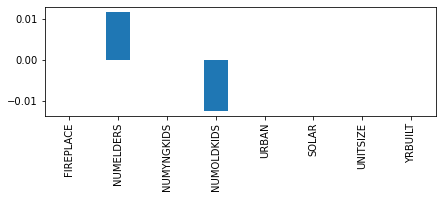

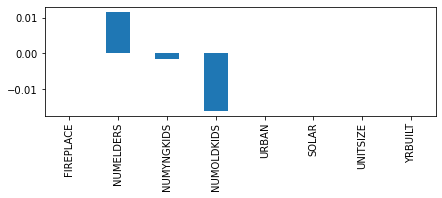

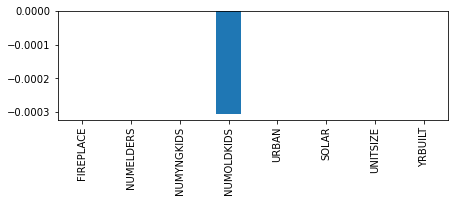

In [213]:
# Convention: lasso coefs (lc), list (L)

# All Income
#lc_ADF = LassoCoeff(lo_ADF, ADF)

# Low Income
lc_LDF = LassoCoeff(lo_LDF, LDF)

# All Income Urban
#lc_ADF_U = LassoCoeff(lo_ADF_U, ADF)

# Low Income Urban
lc_LDF_U = LassoCoeff(lo_LDF_U, LDF)

# All Income Rural
#lc_ADF_R = LassoCoeff(lo_ADF_R, ADF)

# Low Income Rural
lc_LDF_R = LassoCoeff(lo_LDF_R, LDF)

lc_L = [lc_ADF, lc_LDF, lc_ADF_U, lc_LDF_U, lc_ADF_R, lc_LDF_R]

In [234]:
# Storing parameters in coefficient matrices (CM)
CM_ADF = pd.DataFrame([lc_L[0]])
CM_LDF = pd.DataFrame([lc_L[1]])
CM_ADF_U = pd.DataFrame([lc_L[2]])
CM_LDF_U = pd.DataFrame([lc_L[3]])
CM_ADF_R = pd.DataFrame([lc_L[4]])
CM_LDF_R = pd.DataFrame([lc_L[5]])
CM_L = [CM_ADF, CM_LDF, CM_ADF_U, CM_LDF_U, CM_ADF_R, CM_LDF_R]
CM_L_string = ['CM_ADF', 'CM_LDF', 'CM_ADF_U', 'CM_LDF_U', 'CM_ADF_R', 'CM_LDF_R']

# <span style='color:blue'>Non-zero predictors and ranking</span>

In [238]:
def imp_pred(data_list, data_list_string):
    imp = []
    a = 0
    for i in data_list:
        for j in i:
            for k in i[j]:
                if k > 0 or k < 0:
                    imp.append([j, k, data_list_string[a]])
        a += 1
    return imp

In [239]:
CM_imp = imp_pred(CM_L, CM_L_string)

In [246]:
pd.DataFrame(CM_imp, columns=['Feature', 'Importance', 'Dataset']).sort_values(by=['Importance'], ascending=False)

,Feature,Importance,Dataset
0,NUMELDERS,0.011783,CM_LDF
2,NUMELDERS,0.011558,CM_LDF_U
5,NUMOLDKIDS,-0.000307,CM_LDF_R
3,NUMYNGKIDS,-0.001613,CM_LDF_U
1,NUMOLDKIDS,-0.012330,CM_LDF
4,NUMOLDKIDS,-0.015911,CM_LDF_U
